In [1]:
import joblib 
import numpy as np 
from matplotlib import pyplot as plt 
from uncertainties import ufloat, unumpy
from pathlib import Path
from tqdm import tqdm
from numpy import array
import sys
sys.path.append("..")
from core.utils import *
import atlas_mpl_style as ampl
#ampl.use_atlas_style(usetex=False)
import random
import mplhep as hep
hep.style.use("ATLAS")

In [21]:
#nominal_path = '/global/cfs/projectdirs/atlas/wys/QG_Calibration/uncertainty/SFs_pkls'
#nominal_path = Path(nominal_path)

reweighting_vars = ['jet_nTracks', 'GBDT_newScore']
nominal_keys = [reweighting_var + '_quark_reweighting_weights' for reweighting_var in reweighting_vars]
WPs = [0.5, 0.6, 0.7, 0.8]
partons=['Quark','Gluon']
label_ptrange = [500, 600, 800, 1000, 1200, 1500, 2000]
Map_var_title = {
    "jet_pt": "$p_{T}$",
    "jet_nTracks": "$n_{trk}$",
    "jet_trackBDT": "old BDT",
    "jet_eta": "$\eta$",
    "jet_trackC1": "$C_{1}$",
    "jet_trackWidth": "$w^{trk}$",
    "GBDT_newScore": "BDT"
}
Map_gen={
"nominal": "Pythia",
"hadronization/sherpa": "Sherpa (Cluster Had.)",
"hadronization/sherpalund": "Sherpa (String Had.)",
"matrix_element/powhegpythia":"Powheg + Pythia",
"parton_shower/herwigangle":"Herwig (Angluar Shower)",
"parton_shower/herwigdipole":"Herwig (Dipole Shower)",
}

In [3]:
pkl_path = '/global/cfs/projectdirs/atlas/wys/HEP_Repo/QG_Calibration/NewWorkflow/note_plots'
pkl_path = Path(pkl_path)
nominal_path = pkl_path / 'nominal' / 'plots' / 'ADE' / 'Extraction_Results'

def safe_array_divide_unumpy(numerator, denominator):
    if 0 in unumpy.nominal_values(denominator):
        _denominator_nominal_values = unumpy.nominal_values(denominator)
        _denominator_std_devs = unumpy.std_devs(denominator)
        zero_idx = np.where(_denominator_nominal_values==0)[0]
        _denominator_nominal_values[zero_idx] = np.inf
        _denominator_std_devs[zero_idx] = 0 
        _denominator = unumpy.uarray(_denominator_nominal_values, _denominator_std_devs)

        ratio = np.true_divide(numerator, _denominator) 
        # raise Warning(f"0 exists in the denominator for unumpy, check it!")
    else:
        ratio = np.true_divide(numerator, denominator)        
    return ratio

In [29]:
def Plot_WP(WP, var, output_path, period, reweighting_var,
            quark_effs, gluon_rejs, quark_effs_data, gluon_rejs_data,
            syst,if_save=True):
    
    SF_quark = safe_array_divide_unumpy(quark_effs_data, quark_effs)
    SF_gluon = safe_array_divide_unumpy(gluon_rejs_data, gluon_rejs)

    if if_save:
        bin_edges = np.array([500, 600, 800, 1000, 1200, 1500, 2000])
        bin_centers = 1/2 * (bin_edges[:-1] + bin_edges[1:])

        fig, ax0 = plt.subplots()
        if syst == 'nominal':

            #for ii, l_pt in enumerate(label_ptrange[:-1]):
                #plt.scatter(unumpy.nominal_values(quark_effs[ii]),unumpy.nominal_values(gluon_rejs[ii]),label=f'Quark jets {l_pt}',marker='^',color = "blue")
            hep.histplot(unumpy.nominal_values(quark_effs_data),bins=label_ptrange,label='Quark Efficiency, Data',ax=ax0,histtype='errorbar',yerr = unumpy.std_devs(quark_effs_data),xerr=True,marker='.',color = "black")
            hep.histplot(unumpy.nominal_values(quark_effs),bins=label_ptrange,label='Quark Efficiency, Pythia',ax=ax0,histtype='errorbar',yerr = unumpy.std_devs(quark_effs),xerr=True,marker='o',color = "blue",mfc = 'none',markersize=6)

            hep.histplot(unumpy.nominal_values(gluon_rejs_data),bins=label_ptrange,label='Gluon Rejection, Data',ax=ax0,histtype='errorbar',yerr = unumpy.std_devs(gluon_rejs_data),xerr=True,marker='^',color = "green",markersize=6)
            hep.histplot(unumpy.nominal_values(gluon_rejs),bins=label_ptrange,label='Gluon Rejection, Pythia',ax=ax0,histtype='errorbar',yerr = unumpy.std_devs(gluon_rejs),xerr=True,marker='^',color = "red",mfc = 'none',markersize=6)
        else:
            hep.histplot(unumpy.nominal_values(quark_effs),bins=label_ptrange,label=f'Quark Efficiency,{Map_gen[syst]}',ax=ax0,histtype='errorbar',yerr = unumpy.std_devs(quark_effs),xerr=True,marker='^',markersize=5)
            hep.histplot(unumpy.nominal_values(gluon_rejs),bins=label_ptrange,label=f'Gluon Rejection,{Map_gen[syst]}',ax=ax0,histtype='errorbar',yerr = unumpy.std_devs(gluon_rejs),xerr=True,marker='v',markersize=5)

        ax0.legend()
        #ax0.set_ylim(0.8, 1.0) #0.3，1.4
        #ax0.set_xlim(0.5, 0.6)
        ax0.set_ylim(0.3, 1.4)
        ax0.set_xlim(label_ptrange[0], label_ptrange[-1])
        
        #ax0.set_xlabel("Quark Efficiency ")
        #ax0.set_ylabel('Gluon Rejection')
        ax0.set_ylabel("Efficiency or Rejection")
        ax0.set_xlabel('$p_{\mathrm{T}}$ [GeV]')


        #ax0.grid()
#        ax0.set_title(f"{var} for extracted q/g at {WP} WP")
        hep.atlas.label(label='Internal',data=True,ax=ax0,lumi=140)
        WP1 =int(WP*100)
        plt.text(600,1.18,f'{WP1}% WP {Map_var_title[var]}')

        # ax1.errorbar(x = bin_centers, y = unumpy.nominal_values(SF_quark), yerr = unumpy.std_devs(SF_quark), linestyle='none', label = "quark SF", marker='.')
        # ax1.errorbar(x = bin_centers, y = unumpy.nominal_values(SF_gluon), yerr = unumpy.std_devs(SF_gluon), linestyle='none', label = "gluon SF", marker='.')
        # ax1.legend(fontsize = 'x-small')
        # ax1.set_ylim(0.7, 1.3)
        # ax1.set_xlim(bin_edges[0], bin_edges[-1])
        # #ampl.plot.set_xlabel(f"{Map_var_title[var]}")
        # #ax1.set_xticks(bin_edges)
        # ax1.hlines(y = 1, xmin = bin_edges[0], xmax = bin_edges[-1], color = 'gray', linestyle = '--')
        # ax1.set_ylabel("SFs")
        output_path=Path(output_path)
        output_path_new = output_path / period / "WPs" / reweighting_var / var
        if not output_path_new.exists():
            output_path_new.mkdir(parents = True)

        plt.show()
        fig.savefig( output_path_new/ f"{reweighting_var}_WP_{WP}.pdf")
        #plt.close()

    return SF_quark, SF_gluon

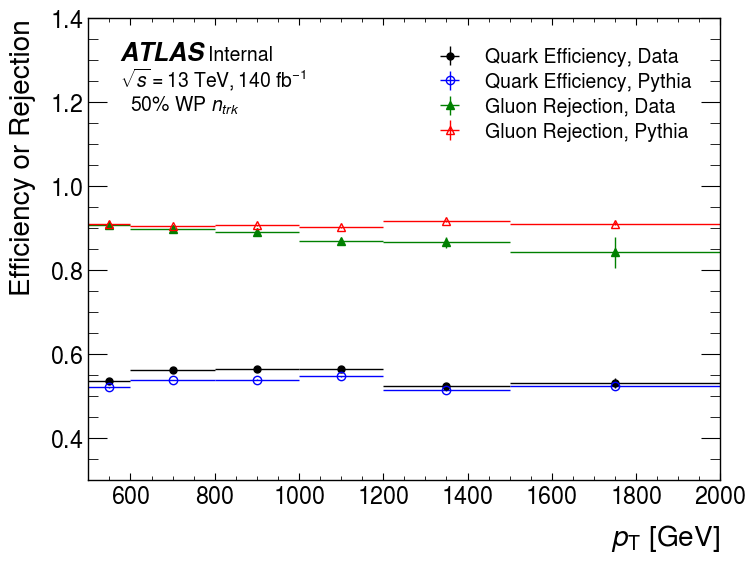

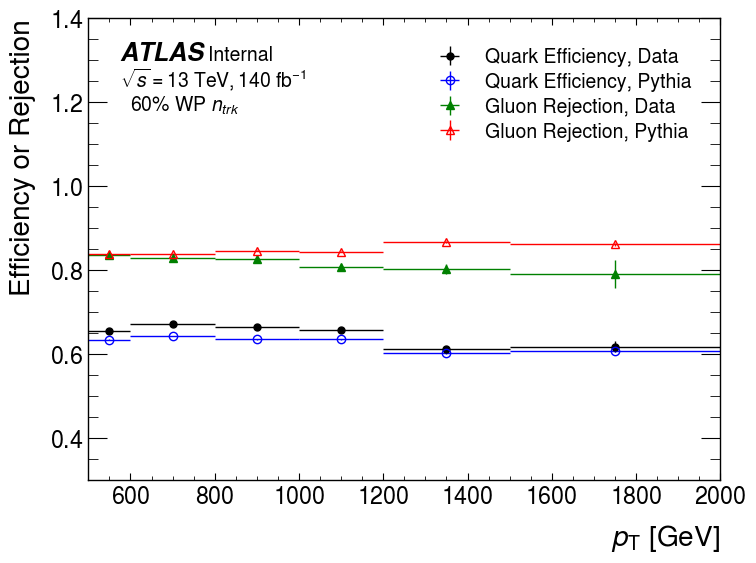

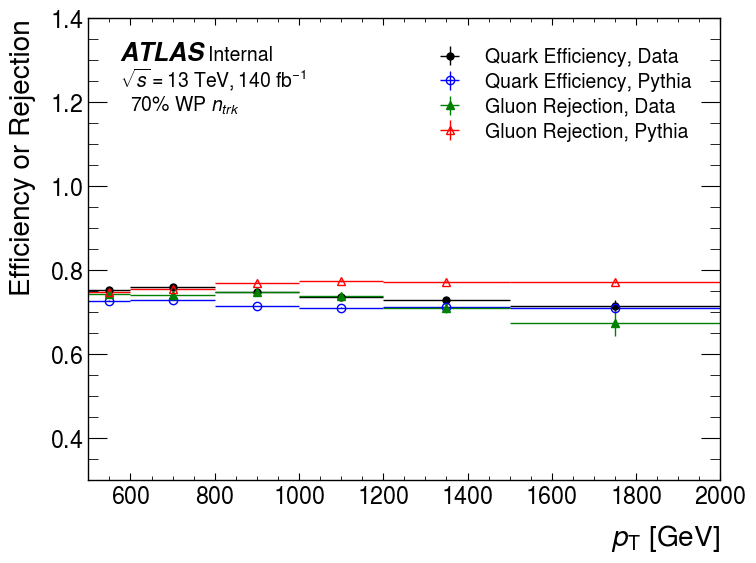

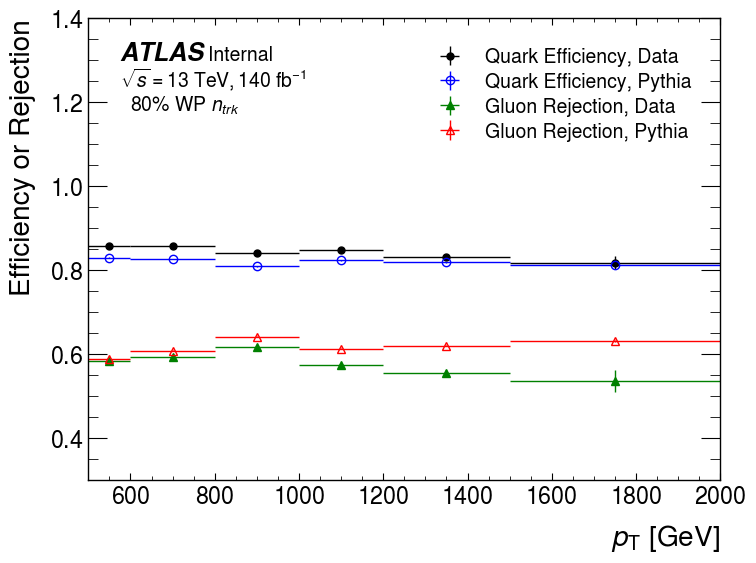

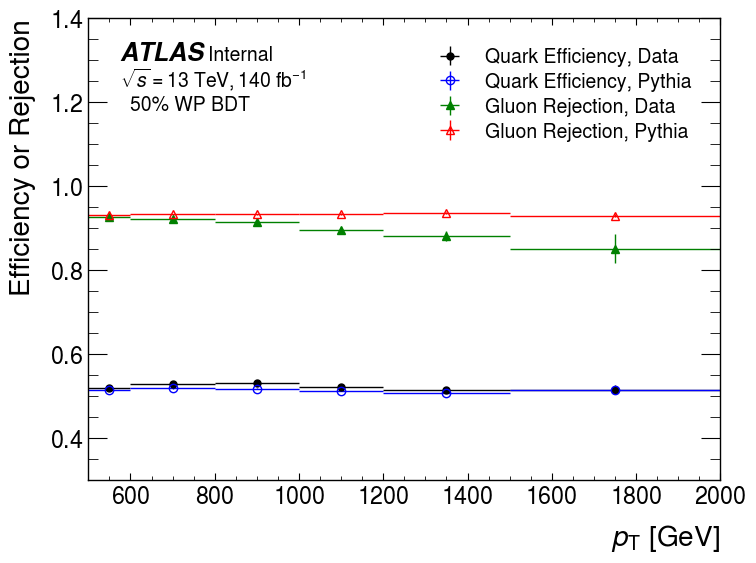

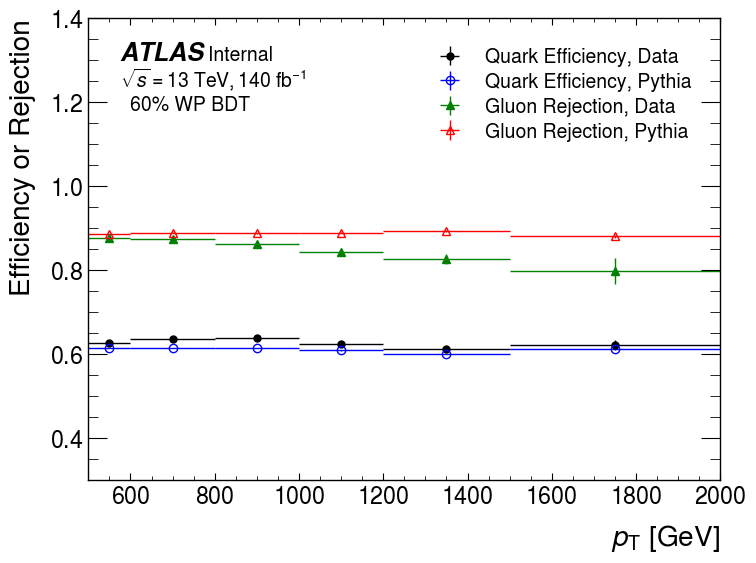

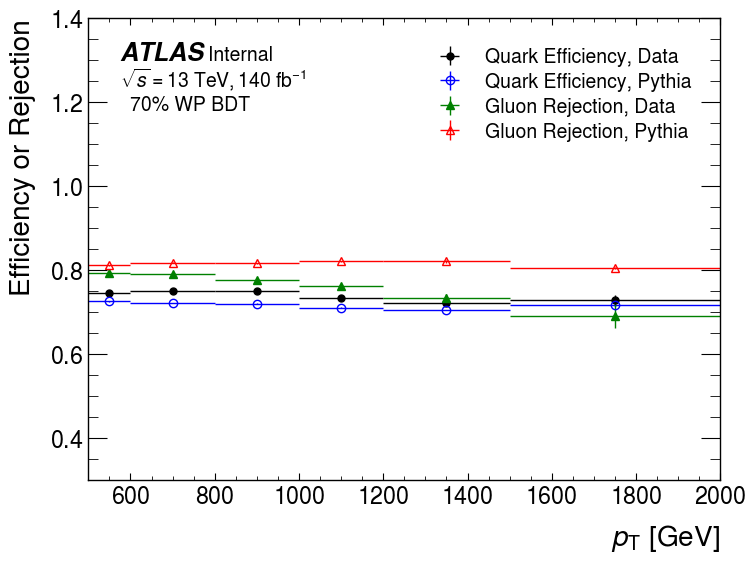

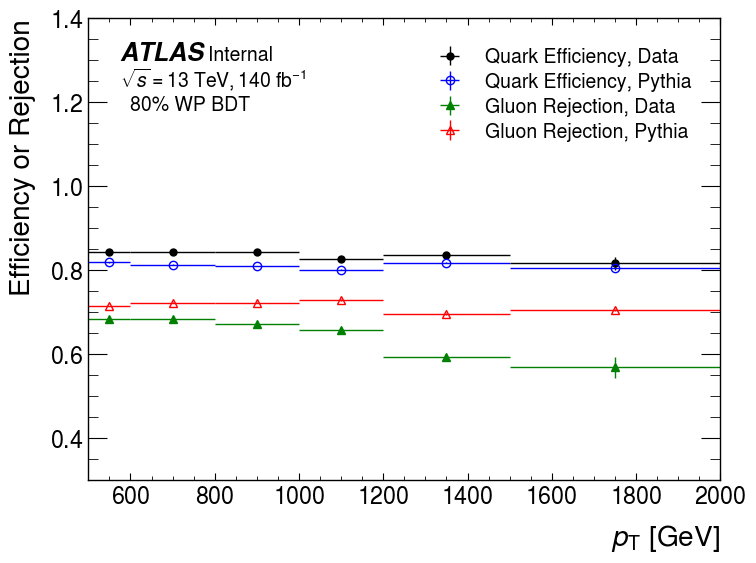

In [30]:
SFs = {}
Eff={}
Extraction_Results={}
syst_list=['nominal']#,'hadronization/sherpa','hadronization/sherpalund','matrix_element/powhegpythia','parton_shower/herwigangle','parton_shower/herwigdipole']
#WP_cut_path = pkl_path/'nominal'/'plots'/'ADE'/'WP_cuts_pkls'/nominal_keys/'WP_cuts.pkl'
#WP_cut = joblib.load(WP_cut_path)
#WP_cut = dict.fromkeys(SF_label_vars)
output_path = '../note_plots'
for var in reweighting_vars:
    SFs[var] = {}
    Eff[var]={}
    WP_cut_path = pkl_path/'nominal'/'plots'/'ADE'/'WP_cuts_pkls'/ f'{var}_quark_reweighting_weights'/'WP_cuts.pkl'
    #WP_cut_path = '/global/cfs/projectdirs/atlas/wys/HEP_Repo/QG_Calibration/NewWorkflow/trained_lightGBM_new_hrzhao/nominal/plots/ADE/WP_cuts_pkls/jet_nTracks_quark_reweighting_weights/WP_cuts.pkl'
    WP_cut = joblib.load(WP_cut_path)
    #WP_cut = dict.fromkeys(var)
    #WP_cut[var] = dict.fromkeys(WPs)
    for syst in syst_list:
        SFs[var][syst]={}
        Eff[var][syst]={} 
        syst_path= pkl_path / syst / 'plots' / 'ADE' / 'Extraction_Results'

        Extraction_Results[syst]= joblib.load(syst_path / f'{var}_Extraction_Results.pkl' )
        for l_pt in label_ptrange[:-1]:
            Extraction_var_pt =  Extraction_Results[syst][var][l_pt]


        for WP in WPs:
            #WP_cut[var][WP] = dict.fromkeys(label_ptrange[:-1])
            SFs[var][syst][WP] = {}
            Eff[var][syst][WP] = {}

            quark_effs_at_pt = []
            gluon_rejs_at_pt = []
            quark_effs_data_at_pt = []
            gluon_rejs_data_at_pt = []
            for ii, l_pt in enumerate(label_ptrange[:-1]):
                extract_p_Quark_MC =  Extraction_Results[syst][var][l_pt]['extract_p_Quark_MC']
                extract_p_Gluon_MC =  Extraction_Results[syst][var][l_pt]['extract_p_Gluon_MC']
                extract_p_Quark_Data =  Extraction_Results[syst][var][l_pt]['extract_p_Quark_Data']
                extract_p_Gluon_Data =  Extraction_Results[syst][var][l_pt]['extract_p_Gluon_Data']

                extract_p_Quark_cum_sum = np.cumsum(unumpy.nominal_values(extract_p_Quark_MC))
                cut = np.where(extract_p_Quark_cum_sum >= WP)[0][0]+1
                #cut = WP_cut[var][WP][l_pt]['idx']
                

                quark_effs_at_pt.append(np.sum(extract_p_Quark_MC[:cut])) 
                gluon_rejs_at_pt.append(np.sum(extract_p_Gluon_MC[cut:]))
                #gluon_rejs_at_pt.append(1.0 - (np.sum(extract_p_Quark_MC[:cut]))) 
                quark_effs_data_at_pt.append(np.sum(extract_p_Quark_Data[:cut]))
                gluon_rejs_data_at_pt.append(np.sum(extract_p_Gluon_Data[cut:]))

            SF_quark, SF_gluon = Plot_WP(WP = WP, var= var, output_path= output_path, 
                    period= 'ADE', reweighting_var = var,
                    quark_effs= quark_effs_at_pt, gluon_rejs = gluon_rejs_at_pt,
                    quark_effs_data=quark_effs_data_at_pt, gluon_rejs_data = gluon_rejs_data_at_pt,syst=syst)
            
            SFs[var][syst][WP]["Quark"] = SF_quark
            SFs[var][syst][WP]["Gluon"] = SF_gluon
            Eff[var][syst][WP]["Quark"] = quark_effs_at_pt
            Eff[var][syst][WP]["Gluon"] = gluon_rejs_at_pt 
            Eff[var][syst][WP]["Quark_data"] = quark_effs_data_at_pt 
            Eff[var][syst][WP]["Gluon_data"] = gluon_rejs_data_at_pt 


In [15]:
Eff

{'jet_nTracks': {'nominal': {0.5: {},
   0.6: {},
   0.7: {},
   0.8: {'Quark': [0.8302278890891499+/-0.0010592007557412501,
     0.8264456031674794+/-0.0007639485383252631,
     0.809365266343291+/-0.0009237963190036027,
     0.8233872217553158+/-0.0012658612138413579,
     0.8186109888154615+/-0.001721558518049968,
     0.8117391510180894+/-0.0014080599522521573],
    'Gluon': [0.588268855188374+/-0.0008299068173534843,
     0.6082589376767754+/-0.0007071008762772123,
     0.6417846236008307+/-0.001048324537341612,
     0.6131830242795122+/-0.0015608139585719535,
     0.6205609272934082+/-0.0018973193422299806,
     0.630798197040125+/-0.0025380648119872366],
    'Quark_data': [0.8567608350904596+/-0.0008605440827229335,
     0.8568988940911441+/-0.0008608530549917092,
     0.8403445557559674+/-0.001820484114452231,
     0.8472495473969286+/-0.0038643900132132153,
     0.8326222478140998+/-0.006893787035250028,
     0.8179769666967264+/-0.015431169950747729],
    'Gluon_data': [0.583

In [23]:
import pandas as pd
jet_pt=['500-600', '600-800', '800-1000','1000-1200','1200-1500','1500-2000']


Eff_syst={}


for var in reweighting_vars:
    Eff_syst[var]={}
    for WP in WPs:
        Eff_syst[var][WP]={}
        for j in partons:
            Eff_syst[var][WP][j]={}
            for syst in syst_list:
                Eff_syst[var][WP][j][f'{Map_gen[syst]}']= unumpy.nominal_values(safe_array_divide_unumpy(Eff[var]['nominal'][WP][j], Eff[var][syst][WP][j]))

            df = pd.DataFrame.from_dict(Eff_syst[var][WP][j], orient="index",columns=jet_pt)
            df[1:].to_latex(f'../tables/SF_MC_{var}_{WP}_{j}.tex',caption=f'Scale Factors of {j} for {var} at {WP} \% WP',label=f'tab:SF_MC_{var}_{WP}_{j}',float_format="%.2f",column_format='ccccccc')


/tmp/ipykernel_16540/1197472791.py:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df[1:].to_latex(f'../tables/SF_MC_{var}_{WP}_{j}.tex',caption=f'Scale Factors of {j} for {var} at {WP} \% WP',label=f'tab:SF_MC_{var}_{WP}_{j}',float_format="%.2f",column_format='ccccccc')
/tmp/ipykernel_16540/1197472791.py:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df[1:].to_latex(f'../tables/SF_MC_{var}_{WP}_{j}.tex',caption=f'Scale Factors of {j} for {var} at {WP} \% WP',label=f't

In [23]:
Eff_syst['jet_nTracks']

{0.5: {'Quark': {'nominal': array([1.0+/-1.974355949949197e-19, 1.0+/-0, 1.0+/-0,
          1.0+/-3.761230419263991e-19, 1.0+/-0, 1.0+/-3.2920599523076865e-19],
         dtype=object),
   'hadronization/sherpa': array([0.9341144740880214+/-0.002915687432520198,
          1.0603326975430543+/-0.0019060185542803091,
          1.0492355041702093+/-0.002238625762924896,
          1.0361005025777785+/-0.003969442997264838,
          0.9501199379019302+/-0.004974675672296583,
          1.0375385701315818+/-0.004211260164822291], dtype=object),
   'hadronization/sherpalund': array([0.9857579917495402+/-0.004586427763049059,
          1.003731963566422+/-0.002377217586926628,
          1.0007555965782855+/-0.00210997628529154,
          1.0883083202045265+/-0.004259535076248312,
          0.9948624291327369+/-0.005266521365683178,
          1.0003658680629823+/-0.0033009671600893703], dtype=object),
   'matrix_element/powhegpythia': array([0.9626975658014307+/-0.001533634952565446,
          1

In [28]:

df.head()

,500-600,600-800,800-1000,1000-1200,1200-1500,1500-2000
nominal,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
hadronization/sherpa,0.934114,1.060333,1.049236,1.036101,0.950120,1.037539
hadronization/sherpalund,0.985758,1.003732,1.000756,1.088308,0.994862,1.000366
matrix_element/powhegpythia,0.962698,1.076796,1.056865,1.035018,1.023289,1.002227
parton_shower/herwigangle,1.002968,1.017459,1.020095,1.019295,1.011170,1.007737


/tmp/ipykernel_3284/3710522159.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(f'../tables/SF_MC.tex',caption=f'Scale Factors of \ntrk at 0.5 \% WP',label=f'tab:SF_MC',float_format="%.2f",column_format='ccccccc')
